<a href="https://colab.research.google.com/github/chsr00/AI_FOR_CAE2/blob/main/GAN_brkt_for_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


GAN

In [5]:
## load modules
import cv2 as cv
import matplotlib.pyplot as plt
import os, time
import numpy as np
#from keras.preprocessing.image import load_img
from tensorflow.keras.utils import load_img
#from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import img_to_array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
print(tf.__version__)

2.12.0


데이터 불러오기

In [6]:
!git clone https://github.com/chsr00/AI_FOR_CAE2.git


! mkdir data_3000
! unzip ./AI_FOR_CAE2/data_3000.zip
! pwd
#! ls -al
#! cd /content/AI_FOR_CAE2
#! ls -al
! mv *.jpg ./data_3000/
#!ls -al ./data_3000


Cloning into 'AI_FOR_CAE2'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 39 (delta 15), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (39/39), 3.95 MiB | 10.10 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Archive:  ./AI_FOR_CAE2/data_3000.zip
  inflating: 22.5651.jpg             
  inflating: 23.119.jpg              
  inflating: 23.149.jpg              
  inflating: 23.2255.jpg             
  inflating: 23.2919.jpg             
  inflating: 23.3077.jpg             
  inflating: 23.3701.jpg             
  inflating: 23.388.jpg              
  inflating: 23.4496.jpg             
  inflating: 23.4706.jpg             
  inflating: 23.4709.jpg             
  inflating: 23.4904.jpg             
  inflating: 23.5079.jpg             
  inflating: 23.5414.jpg             
  inflating: 23.5748.jpg             
  inflating: 23.5762.jpg             
  inflating: 23.587.jpg   

In [7]:
# 압축해제된 데이터 경로를 찾아 복사해서 붙여넣어주세요
src = './data_3000/'
img_size = 56       # 이미지 사이즈
channels = 1
noise_dim = 100
#이미지 읽기
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)
    return img
def get_data():
    #src 경로에 있는 파일 명을 저장합니다.
    files = os.listdir(src)
    X = []

    # 경로와 파일명을 입력으로 넣어 확인하고
    # 데이터를 255로 나눠서 0~1사이로 정규화 하여 X 리스트에 넣습니다.

    for file in files:

        X.append((img_read(src,file)-127.5)/127.5)


    # Train set(80%), Test set(20%)으로 나누기
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=1,shuffle=True)

    # (x, 56, 56, 1) 차원으로 맞춰줌
    X_train = np.expand_dims(X_train, axis=3)
    X_test = np.expand_dims(X_test, axis=3)


    return X_train, X_test

# 데이터 셋 불러옴 (이미지만 필요해서 y 라벨 필요 없음)
X_train, X_test = get_data()
print("X_train.shape = {}".format(X_train.shape))
print("X_test.shape = {}".format(X_test.shape))

X_train.shape = (2400, 56, 56, 1)
X_test.shape = (600, 56, 56, 1)


IMAGE 확인용

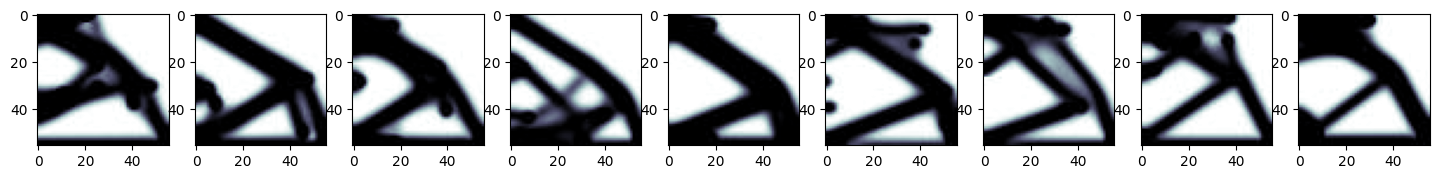

In [8]:
# images 확인용
fig = plt.figure(figsize=(20,20))
nplot = 10
for i in range(1,nplot):
    ax = fig.add_subplot(1,nplot,i)
    ax.imshow(X_train[i, :, :, 0],cmap = plt.cm.bone)
plt.show()

In [9]:
# ---------------------
#  Generator 모델 구성 (input : noise / output : image)
# ---------------------

def build_generator():
    model = Sequential()

    model.add(layers.Dense(256, use_bias=False, input_shape=(100,)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))

    model.add(layers.LeakyReLU(alpha=0.2))                             #추가한 6줄
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(2048))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))

    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(np.prod(56*56), activation='tanh'))
    model.add(layers.Reshape((56,56,1)))
    # noise 텐서 생성, model에 noise 넣으면 이미지 나옴
    noise = Input(shape=(100,))
    img = model(noise)
    model.summary()
    return Model(noise,img)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25600     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                        

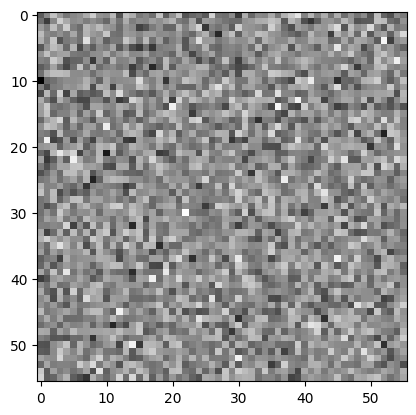

In [10]:
# Optimizer
optimizer = Adam(0.0002, 0.5)

# generator 모델 생성과 컴파일(loss함수와 optimizer 설정)
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

# 노이즈 만들어서 generator에 넣은 후 나오는 이미지 출력 (확인용)
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# plot_model(generator, show_shapes=True)

modelfit

In [11]:
# ---------------------
#  Discriminator 모델 구성 (input : image / output : 판별값(0에서 1사이의 숫자))
# ---------------------
def build_discriminator():
    model = tf.keras.Sequential()
    img_shape = (img_size, img_size, channels)
    model.add(layers.Flatten(input_shape=img_shape))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(1024))                                #추가 한부분 4줄
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()
    # 이미지 들어갈 텐서 생성, model에 넣으면 판별값 나옴
    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [12]:
# discriminator 모델 생성과 컴파일(loss함수와 optimizer 설정, accaracy 측정)
discriminator = build_discriminator()
discriminator.compile(loss = 'binary_crossentropy',optimizer = optimizer, metrics   = ['accuracy'])

# image를 discriminator에 넣었을 때 판별값 나옴 (예시. 확인용)
decision = discriminator(generated_image)
print (decision)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1606144   
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 512)              

In [13]:
# Combined Model
# 랜덤으로 만든 이미지로부터 학습해서 새로운 이미지를 만들어내는 generator의 데이터를 discriminator가 분류.

z = layers.Input(shape=(100,), name="noise_input")
img = generator(z)

# 모델을 합쳐서 학습하기 때문에 발란스 때문에 discriminator는 학습을 꺼둠. 우리는 generator만 학습
discriminator.trainable = False

# discriminator에 이미지를 입력으로 넣어서 진짜이미지인지 가짜이미지인지 판별
valid = discriminator(img)

# generator와 discriminator 모델 합침. (노이즈가 인풋으로 들어가서 판별결과가 아웃풋으로 나오게)
# discriminator를 속이도록 generator를 학습
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
combined.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 noise_input (InputLayer)    [(None, 100)]             0         
                                                                 
 model (Functional)          (None, 56, 56, 1)         8113728   
                                                                 
 model_1 (Functional)        (None, 1)                 2787841   
                                                                 
Total params: 10,901,569
Trainable params: 8,104,000
Non-trainable params: 2,797,569
_________________________________________________________________


In [14]:
def train(epochs, batch_size=128, sample_interval=50):

        # 정답으로 사용 할 매트릭스. valid는 1, fake는 0
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        history = []
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # batch_size만큼 이미지와 라벨을 랜덤으로 뽑음
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise 생성(batch_size만큼)
            noise = np.random.normal(0, 1, (batch_size, 100))

            # noise를 generator에 넣어서 fake image 이미지 생성
            gen_imgs = generator.predict(noise)

            # discriminator를 학습함. 진짜 이미지는 1이 나오게, 가짜 이미지는 0이 나오게
            # discriminator가 이미지를 판별한 값과 valid와 fake가
            # 각각 같이 들어가서 binary_crossentropy으로 계산되어 업데이트함.
            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

            # real을 넣었을 때와 fake를 넣었을 때의 discriminator의 loss값과 accracy값의 평균을 구함.
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # noise 생성
            noise = np.random.normal(0, 1, (batch_size, noise_dim))

            # noise가 들어가서 discriminator가 real image라고 판단하도록 generator를 학습
            g_loss = combined.train_on_batch(noise, valid)

            history.append({"D":d_loss[0],"G":g_loss})

            # sample_interval(1000) epoch 마다 loss와 accuracy와 이미지 출력
#            print('sample_interval',sample_interval)
            if epoch % sample_interval == 0:
                print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                sample_images(epoch)
        return(history)

In [15]:
 # 이미지 출력
 # generator가 얼마나 학습이 잘 되었는지는 단지 loss값만으로는 파악이 어려움 -> 직접 image 확인해봐야 함
def sample_images(epoch):
        n = 10  # how many digits we will display
        noise = np.random.normal(0, 1, (n, noise_dim))
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        plt.figure(figsize=(15, 4))

        for i in range(n):
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(gen_imgs[i].reshape(56,56), vmin=0, vmax=1, cmap=plt.cm.bone)
            #plt.title("Gen"+str(i))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
#           fig.savefig("images/%d.png" % epoch)
#        plt.close()

In [16]:
# GAN 실행
history=train(epochs=1001, batch_size=32, sample_interval=100)

1/1 [==============================] - 0s 378ms/step


KeyError: ignored

In [ ]:
# summarize history for loss
import pandas as pd
hist = pd.DataFrame(history)
plt.figure(figsize=(10,5))
for colnm in hist.columns:
    plt.plot(hist[colnm],label=colnm)
plt.legend()
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

In [ ]:
generated_image = generator(tf.random.normal([1, noise_dim]))
plt.imshow(tf.reshape(generated_image, shape = (56,56)), cmap=plt.cm.bone)